# Testing thresholds for calling mQTL
There are two methods I'm looking at by which mQTL are called, and I'm exploring them here:
1. A staged method as in [Oliva et al, 2020](https://doi.org/10.1126/science.aba3066)
    1. First take bonferroni corrected threshold to take into account the number of independent mQTL tested per CpG site
    1. Next compute the storey *qvalue* across CpG sites to identify CpG with at least one significant mQTL at an FDR of <= 0.25
1. Adaptive Groupwise BH FDR method as shown in [Sankaran and Holmes 2014](https://pubmed.ncbi.nlm.nih.gov/26917999/) and as described in [Hu, Zhao, and Zhou, 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3175141/)
    1. First estimate $\pi_{0,g}$, or the proportion of true NULL hypotheses in each group
        1. There are a few ways to estimate this, the least-slope method (LSL) which works well when signals are sparse and has nice empirical properties (quoting here from above 2010 paper)
        1. Two-Stage method which was shown in this paper to be consistent, as was LSL
    1. Reweight P-values by $\pi_{g,0}$, and reject $k$ hypotheses ranking weighted hypotheses $P^{W}_{(i)}$ such that 

$$k = \text{max} \Bigg\{ i: P^{W}_{(i)} \leq \frac{i\alpha^W}{N}\Bigg\}, \text{where } \alpha^W = \frac{\alpha}{1 - \pi_0} \text{and } \pi_0 = \frac{1}{N} \sum_{g=1}^K n_g \pi_{g,0} $$

In [1]:
library(data.table)
library(qvalue)
library(here)
library(structSSI)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL



## Testing on marginal data
### Staged method|

In [2]:
meta_marginal < -fread(here("data", "delahaye_richs_marginal_mecs_maf01.txt.gz"))

In [3]:
meta_marginal_bonf_cpg <- meta_marginal[,.SD[p < (0.05 / .N)],by="Probe"]
meta_marginal_bonf_cpg <- meta_marginal_bonf_cpg[,.SD[which.min(p)],by="Probe"]

[1] 1.384045e-05

[1] 1

Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(pi0):
“no non-missing arguments to max; returning -Inf”
Warning message in min(pi0):
“no non-missing arguments to min; returning Inf”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


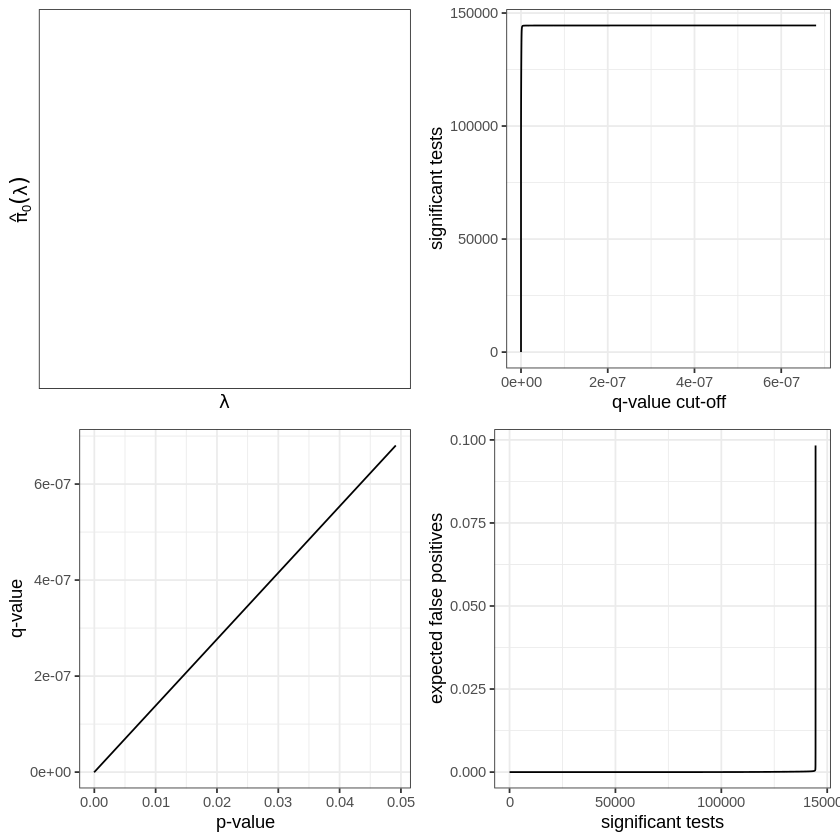

Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(pi0):
“no non-missing arguments to max; returning -Inf”
Warning message in min(pi0):
“no non-missing arguments to min; returning Inf”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


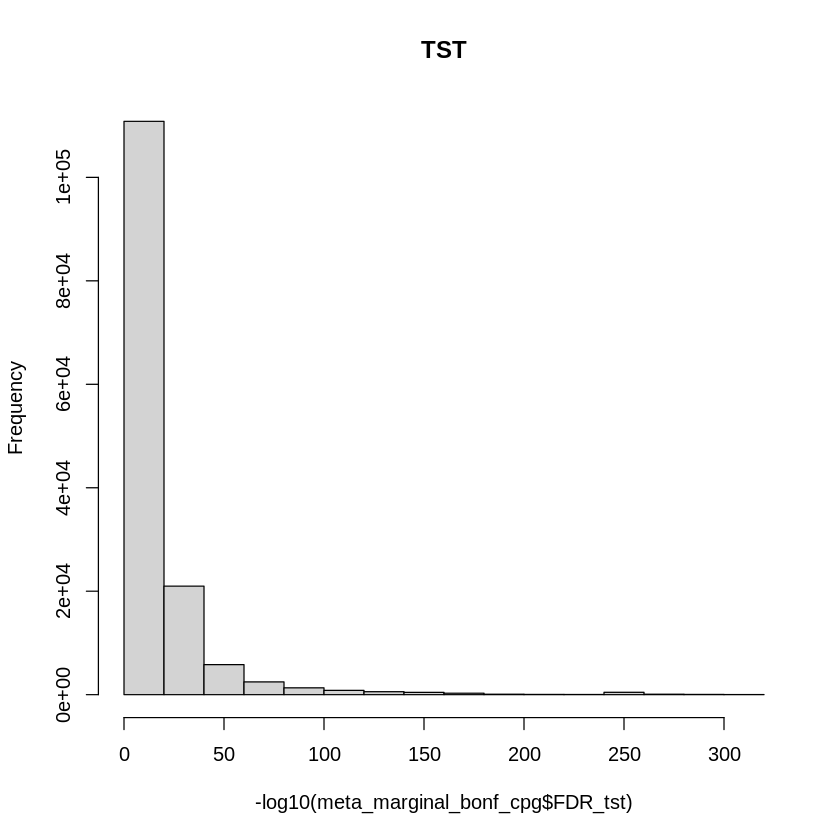

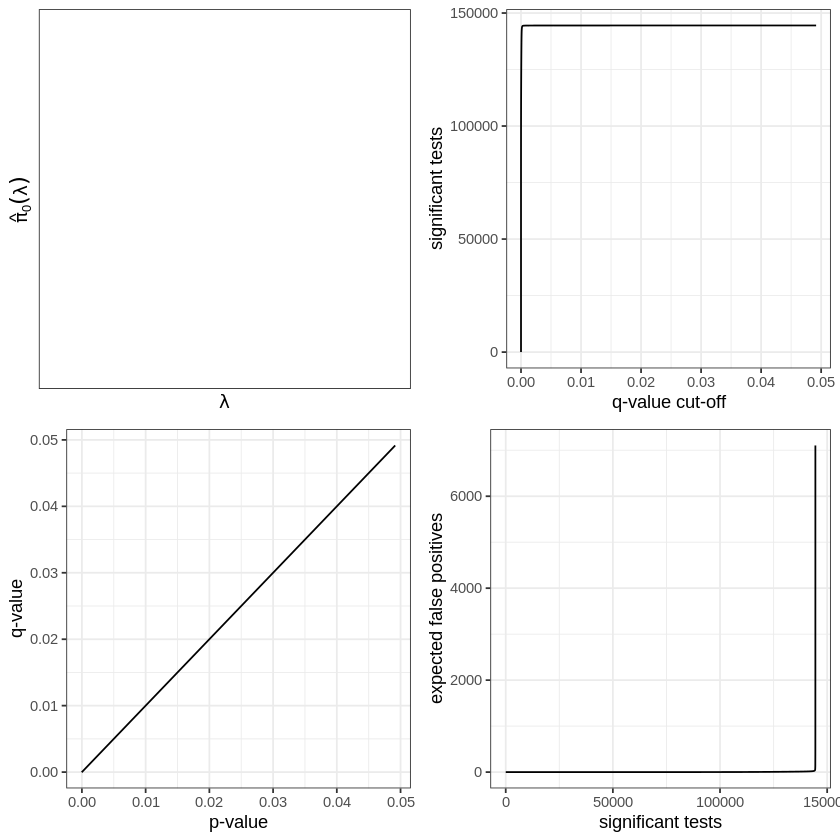

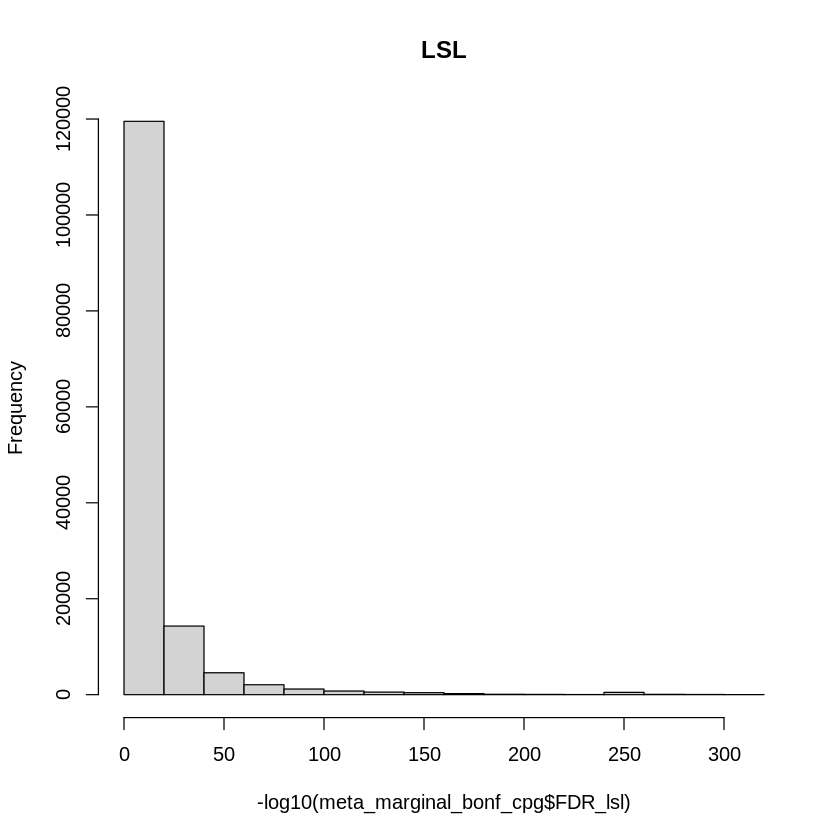

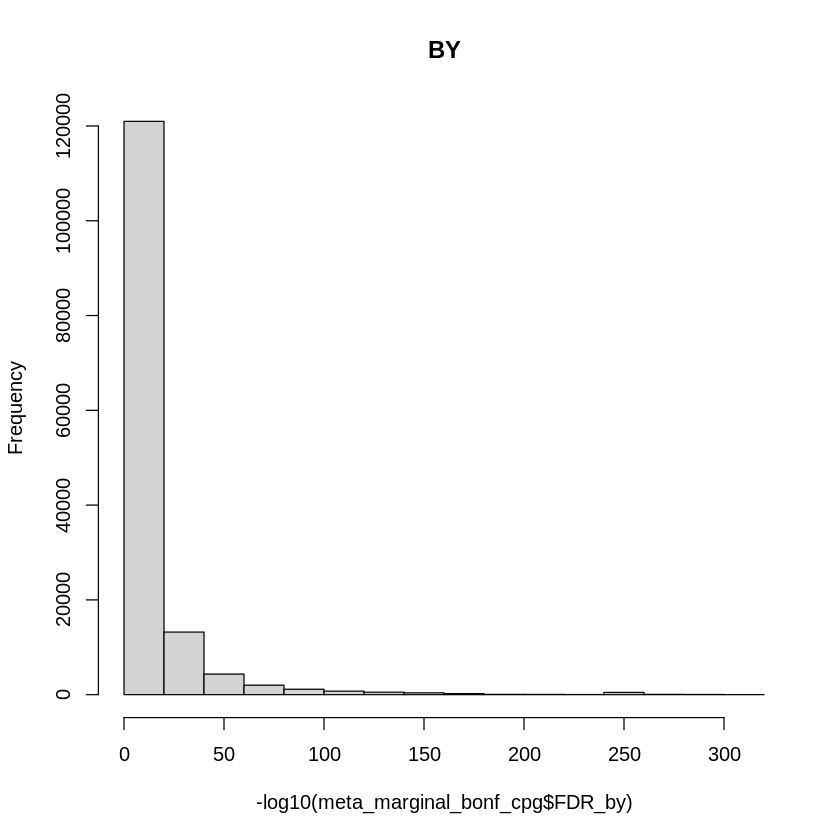

In [4]:
qval_tst <- qvalue(meta_marginal_bonf_cpg$p,pi0=estimate.pi0(meta_marginal_bonf_cpg$p,method = "tst"))
qval_lsl <- qvalue(meta_marginal_bonf_cpg$p,pi0=estimate.pi0(meta_marginal_bonf_cpg$p,method = "lsl"))

meta_marginal_bonf_cpg$FDR_tst <- qval_tst$qvalues
meta_marginal_bonf_cpg$FDR_lsl <- qval_lsl$qvalues
meta_marginal_bonf_cpg$FDR_by <- p.adjust(meta_marginal_bonf_cpg$p,method="BY")

estimate.pi0(meta_marginal_bonf_cpg$p,method = "tst")
estimate.pi0(meta_marginal_bonf_cpg$p,method = "lsl")

plot(qval_tst)
hist(-log10(meta_marginal_bonf_cpg$FDR_tst), main = "TST")
plot(qval_lsl)
hist(-log10(meta_marginal_bonf_cpg$FDR_lsl), main = "LSL")
hist(-log10(meta_marginal_bonf_cpg$FDR_by), main = "BY")

In [5]:
dim(meta_marginal_bonf_cpg)
dim(meta_marginal_bonf_cpg[FDR_tst < 0.05])
dim(meta_marginal_bonf_cpg[FDR_lsl < 0.05])
dim(meta_marginal_bonf_cpg[FDR_by < 0.05])
fwrite(meta_marginal_bonf_cpg[FDR_by < 0.05],here("data","meta_marginal_bonf_cpg.txt.gz"),sep='\t',quote=FALSE,row.names=FALSE)

[1] 144504     17

[1] 144504     17

[1] 144504     17

[1] 144490     17

###  Groupwise FDR

ERROR: Error in if (is.na(spval[i])) tmp[i] <- NA: argument is of length zero


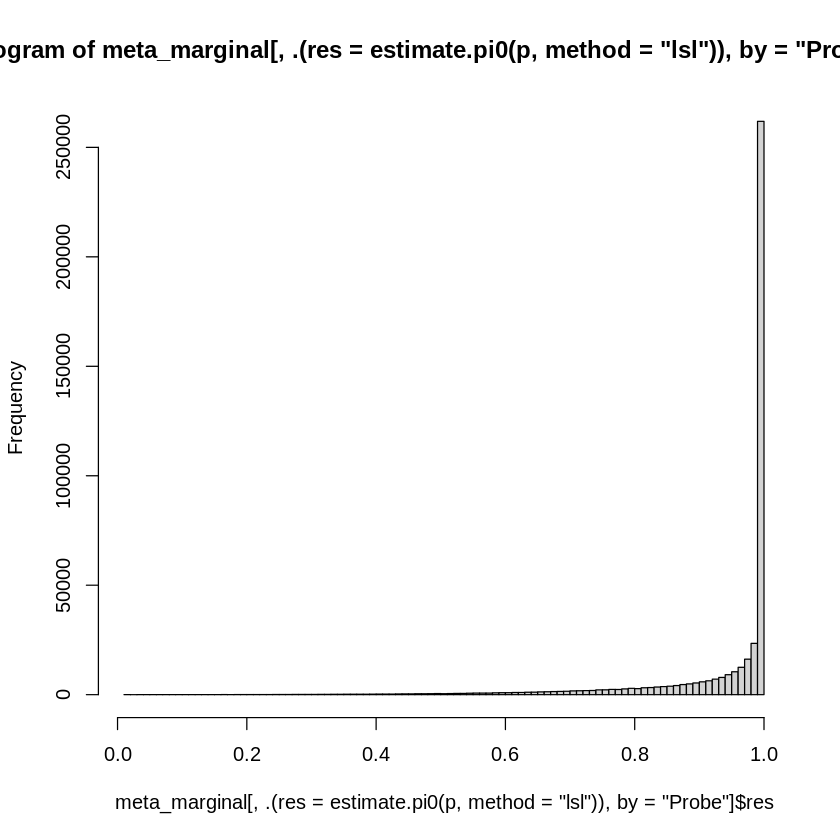

In [15]:
pi_prop <- function(p,method){
    pi0 <- estimate.pi0(p,method=method)
    pi1 <- 1 - pi0
    return(ifelse(pi0 == 1,Inf,(pi0/pi1)))
}
hist(meta_marginal[,.(res=estimate.pi0(p,method='lsl')), by="Probe"]$res,breaks = 100)
# hist(meta_marginal[,.(res=estimate.pi0(p,method='tst')), by="Probe"]$res,breaks = 100) # Returns NA for this data

In [25]:
meta_marginal[,`:=`(
        p_weighted = pi_prop(p,method = 'lsl') * p,
        pi_g=estimate.pi0(p,method='lsl')
    ),
    by = "Probe"
]

In [30]:
pi_0 <- sum(meta_marginal[,.(res=.N * unique(pi_g)),by="Probe"]$res) /nrow(meta_marginal) 
pi_0 
a_w <- (0.05) / (1 - pi_0)

[1] 0.9361095

In [39]:
meta_marginal[,`:=`(
        i_rank = rank(p_weighted,ties.method = "max")
    )
]
rank_threshold <- max(meta_marginal[p_weighted  <= ((i_rank * a_w)/.N)]$i_rank)
meta_marginal_gbhfdr <- meta_marginal[i_rank <= rank_threshold]

SNP,Chr,BP,A1,A2,Freq,Probe,Probe_Chr,Probe_bp,Gene,Orientation,b,SE,p,p_lsl,p_weighted,pi_g,i_rank
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
rs62396080,6,26538276,T,C,0.0126571,cg11502198,6,26597334,cg11502198,+,0.000964817,0.064805,0.988122,0.02575673,0.02575673,0.02540416,12110920


V1,V2,N
<int>,<int>,<int>
3598236,179661,13892522


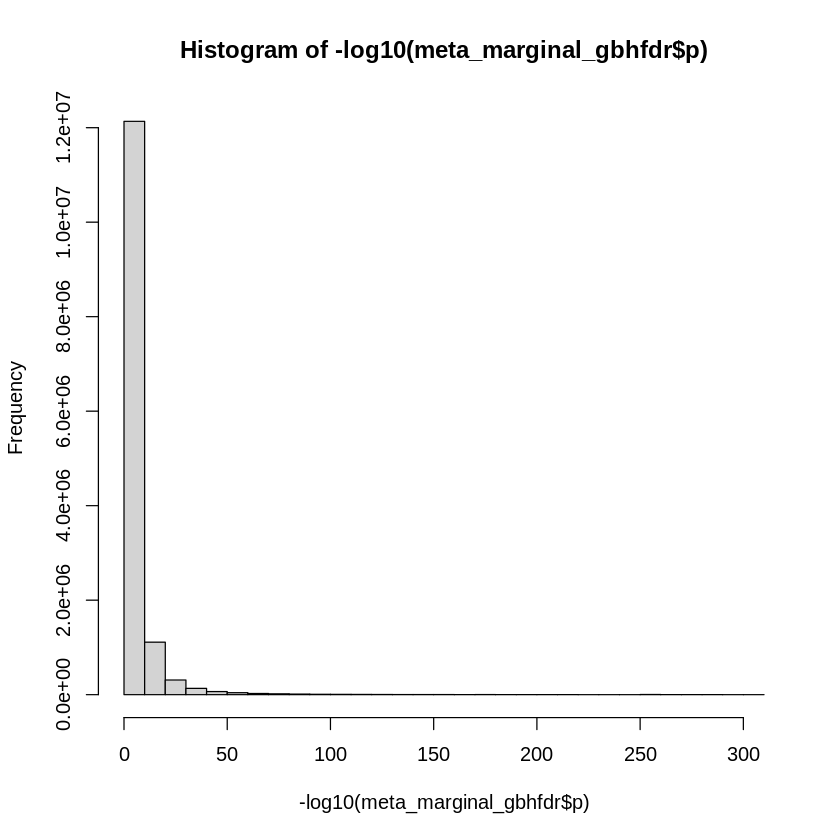

In [40]:
hist(-log10(meta_marginal_gbhfdr$p))
meta_marginal_gbhfdr[,.SD[which.max(p)]]
meta_marginal_gbhfdr[,.(uniqueN(SNP),uniqueN(Probe),.N)]

In [41]:
a_w
rank_threshold

[1] 0.7825889

[1] 13892522